In [44]:
# Importação das bibliotecas necessárias

import pandas as pd
from nltk.corpus import stopwords
from nltk import FreqDist, WordPunctTokenizer, WhitespaceTokenizer, RSLPStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from unidecode import unidecode
import seaborn as sns
import joblib

In [45]:
df = pd.read_csv('dataset_avaliacoes.csv')

df.head()

,ID_avaliacao,avaliacao,nota,sentimento
0,81841,"Esse smartphone superou minhas expectativas, r...",5,positivo
1,28031,o cheiro e muito desagradavel!! pra quem se in...,2,negativo
2,91332,"Eu fiz a compra a loja não entregou o produto,...",1,negativo
3,110045,"Atendeu minhas expectativas, só achei a luz ru...",4,positivo
4,36929,"Gostei muito, só achei que ficou a desejar a q...",5,positivo


Faz todo o processo de tratamento de dados textuais e armazena numa nova coluna *frase_tratada*.
- Remoção de acentuação
- Remoção das palavras irrelevantes
- Normalização do texto em letras minúsculas
- Remoção dos caracteres especiais

In [46]:
processed_texts = []

# Cria uma instância da classe de tokenização que também considera pontuação
tokenizer = WordPunctTokenizer()

# Cria uma instância do stemmer para lingua portuguesa (para simplificar as palavras)
stemmer = RSLPStemmer()

# Adquire todas as stopwords da lingua portuguesa (artigos, conjunções, preposições, etc)
useless_words = stopwords.words('portuguese')

# Remove todos os acentos das frases do dataset e armazena numa variável
texts = [unidecode(text) for text in df['avaliacao']]

# Remove todos os acentos das palavras irrelevantes
useless_words = [unidecode(text) for text in useless_words]

# Cria uma nova coluna no dataFrame sem acentuação
df['frase_tratada'] = texts

for txt in df['frase_tratada']:
    # Normaliza o texto para letras minúsculas
    txt = txt.lower()

    # Realiza a tokenização da avaliação
    token_words = tokenizer.tokenize(txt)

    # Verifica se os tokens (palavras) são letras (isalpha) e que não esteja na lista de stopwords
    # Ao final, realiza a simplificação da palavra com a técnica "stemming"
    processed_words = [stemmer.stem(word) for word in token_words if word.isalpha() and word not in useless_words]

    # Junta todas as palavras no array em uma única string
    processed_texts.append(' '.join(processed_words))

df['frase_tratada'] = processed_texts
df.head()

,ID_avaliacao,avaliacao,nota,sentimento,frase_tratada
0,81841,"Esse smartphone superou minhas expectativas, r...",5,positivo,smartphon super expect recom
1,28031,o cheiro e muito desagradavel!! pra quem se in...,2,negativo,cheir desagrada pra incomod recomendo
2,91332,"Eu fiz a compra a loja não entregou o produto,...",1,negativo,fiz compr loj entreg produt compr feit carta c...
3,110045,"Atendeu minhas expectativas, só achei a luz ru...",4,positivo,atend expect ach luz ruim nad dificult funcion
4,36929,"Gostei muito, só achei que ficou a desejar a q...",5,positivo,gost ach fic desej qual fot ach bem melhor


In [47]:
# Treina e testa um modelo com CountVectorizer
def classificar_texto(data, coluna_texto, coluna_classificacao):
    vetorizar = CountVectorizer(lowercase=False, max_features=50)
    bag_of_words = vetorizar.fit_transform(data[coluna_texto])

    SEED = 42
    X_train, X_test, y_train, y_test = train_test_split(bag_of_words, data[coluna_classificacao], random_state=SEED)

    regressao_logistica = LogisticRegression()
    regressao_logistica.fit(X_train, y_train)

    acuracia = regressao_logistica.score(X_test, y_test)
    print(f'Acurácia do modelo com a coluna "{coluna_texto}": {acuracia*100:.2f}%')

# Treina e testa um modelo com TF-IDF e N-Grams
def classificar_texto_tfidf(data, coluna_texto, coluna_classificacao):
    # Considerará tanto unigramas (palavras individuais) quanto bigramas (pares de palavras consecutivas)
    vetorizar = TfidfVectorizer(lowercase=False, max_features=2000, ngram_range=(1,2))
    bag_of_words = vetorizar.fit_transform(data[coluna_texto])

    SEED = 42
    X_train, X_test, y_train, y_test = train_test_split(bag_of_words, data[coluna_classificacao], random_state=SEED)

    regressao_logistica = LogisticRegression()
    regressao_logistica.fit(X_train, y_train)

    acuracia = regressao_logistica.score(X_test, y_test)
    print(f'Acurácia do modelo com TF-IDF e N-Grams: {acuracia*100:.2f}%')

# Gera um gráfico de barras sobre a frequência das palavras
def grafico_frequencia(data, coluna_texto, quantidade):
    todas_palavras = ' '.join([texto for texto in data[coluna_texto]])
    tokenizador = WhitespaceTokenizer()
    frequencia = FreqDist(tokenizador.tokenize(todas_palavras))

    df_frequencia = pd.DataFrame({
        "palavra": list(frequencia.keys()),
        "frequencia": list(frequencia.values())
    })

    df_frequencia.sort_values('frequencia', ascending=False, inplace=True)

    plt.figure(figsize=(12,6))
    ax = sns.barplot(df_frequencia.head(quantidade), x='palavra', y='frequencia')
    ax.set(ylabel='Contagem', xlabel='Palavra')
    plt.xticks(rotation=45)
    

Acurácia do modelo com a coluna "frase_tratada": 85.32%


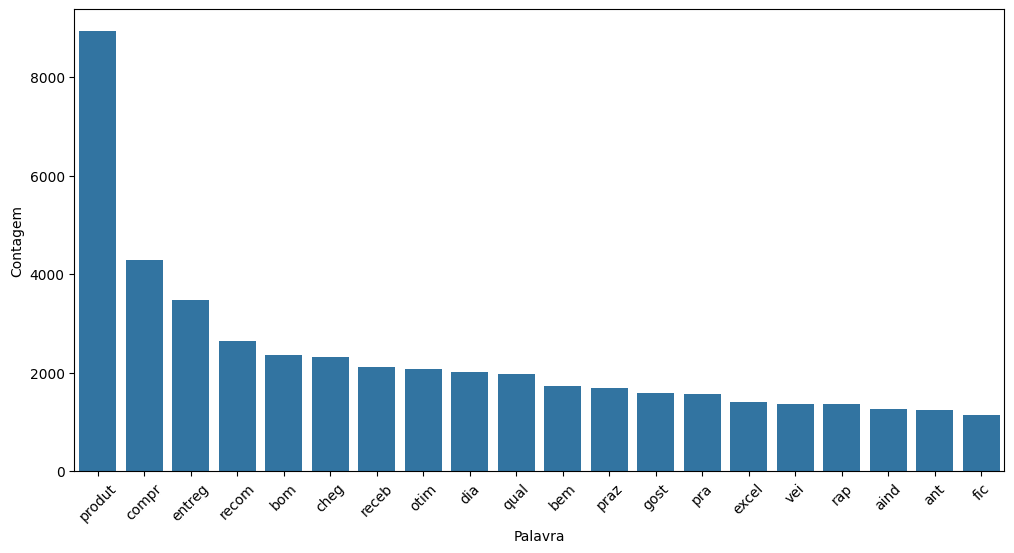

In [48]:
classificar_texto(df, 'frase_tratada', 'sentimento')
grafico_frequencia(df, 'frase_tratada', 20)

In [49]:
classificar_texto_tfidf(df, 'frase_tratada', 'sentimento')

Acurácia do modelo com TF-IDF e N-Grams: 92.70%


### Criando o modelo e vetorização para exportação

In [50]:
vectorizer = TfidfVectorizer(lowercase=False, max_features=2000, ngram_range=(1,2))
bag_of_words = vectorizer.fit_transform(df['frase_tratada'])

SEED = 42

X_train, X_test, y_train, y_test = train_test_split(bag_of_words, df['sentimento'], random_state=SEED)

regressao_logistica = LogisticRegression()
regressao_logistica.fit(X_train, y_train)
acuracia = regressao_logistica.score(X_test, y_test)
print(f'Acurácia do modelo com TF-IDF e N-Grams: {acuracia*100:.2f}%')

joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(regressao_logistica, 'modelo_regressao_logistica.pkl')

Acurácia do modelo com TF-IDF e N-Grams: 92.70%


['modelo_regressao_logistica.pkl']

### Classificando novas avaliações

**Função para processar novos dados**

In [51]:
from typing import List

# Define o parâmetro como uma lista de strings
def word_processing(array_texts: List[str]):
    processed_texts = []

    # Cria uma instância da classe de tokenização que também considera pontuação
    tokenizer = WordPunctTokenizer()

    # Cria uma instância do stemmer para lingua portuguesa (para simplificar as palavras)
    stemmer = RSLPStemmer()

    # Adquire todas as stopwords da lingua portuguesa (artigos, conjunções, preposições, etc)
    useless_words = stopwords.words('portuguese')

    # Remove todos os acentos das frases do dataset e armazena numa variável
    texts = [unidecode(text) for text in array_texts]

    # Remove todos os acentos das palavras irrelevantes
    useless_words = [unidecode(text) for text in useless_words]

    for txt in texts:
        # Normaliza o texto para letras minúsculas
        txt = txt.lower()

        # Realiza a tokenização da avaliação
        token_words = tokenizer.tokenize(txt)

        # Verifica se os tokens (palavras) são letras (isalpha) e que não esteja na lista de stopwords
        # Ao final, realiza a simplificação da palavra com a técnica "stemming"
        # O Stemming por padrão já transforma as palavras para minúsculas
        processed_words = [stemmer.stem(word) for word in token_words if word.isalpha() and word not in useless_words]

        # Junta todas as palavras no array em uma única string
        processed_texts.append(' '.join(processed_words))

    return processed_texts

In [52]:
# Novas avaliações para prever
new_reviews = ["Ótimo produto, super recomendo!",
                 "A entrega atrasou muito! Estou decepcionado com a compra",
                 "Muito satisfeito com a compra. Além de ter atendido as expectativas, o preço foi ótimo",
                 "Horrível!!! O produto chegou danificado e agora estou tentando fazer a devolução.",
                 '''Rastreando o pacote, achei que não fosse recebê-lo, pois, na data prevista, estava sendo entregue em outra cidade.
                 Mas, no fim, deu tudo certo e recebi o produto.Produto de ótima qualidade, atendendo bem as minhas necessidades e por
                 um preço super em conta.Recomendo.''']

reviews_processed = word_processing(new_reviews)
reviews_processed

['otim produt sup recom',
 'entreg atras decepcion compr',
 'satisfeit compr alem ter atend expect prec otim',
 'horri produt cheg danific agor tent faz devoluca',
 'rastre pacot ach receb lo poi dat prev send entreg outr cidad fim deu tud cert receb produt produt otim qual atend bem necess prec sup cont recom']

In [53]:
# Importa o modelo e vetorizador tf-idf
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
model = joblib.load('modelo_regressao_logistica.pkl')

words_tfidf = tfidf_vectorizer.transform(reviews_processed)

predicts = model.predict(words_tfidf)

df_predicts = pd.DataFrame({
    "Avaliação": new_reviews,
    "Sentimento previsto": predicts
})

df_predicts

,Avaliação,Sentimento previsto
0,"Ótimo produto, super recomendo!",positivo
1,A entrega atrasou muito! Estou decepcionado co...,negativo
2,Muito satisfeito com a compra. Além de ter ate...,positivo
3,Horrível!!! O produto chegou danificado e agor...,negativo
4,"Rastreando o pacote, achei que não fosse receb...",positivo
